In [1]:
# install all needed modules with provided requirements file

import os
running_local = True if os.getenv('JUPYTERHUB_USER') is None else False
    
if running_local:
    import sys
    !{sys.executable} -m pip install -r requirements_qlearn.txt

^C


In [1]:
import matplotlib
import matplotlib.pyplot as plt
import gym
import numpy as np
import os

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from torchsummary import summary

from tqdm import trange
import pandas as pd

%matplotlib inline

In [2]:
# Check if GPU is available  
cuda_available = torch.cuda.is_available()

# Set a seed for reproducing results
random_seed = 1234
np.random.seed(random_seed)

torch.manual_seed(random_seed)
if cuda_available:
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

In [3]:
class Network(nn.Module):
    """
    A fully connected neural network with 1 hidden layer.
    """
    def __init__(self, env):
        super(Network, self).__init__()
        self.env = env
        self.state_space = env.observation_space.shape[0]
        self.action_space = env.action_space.n
        self.hidden = 200
        self.l1 = nn.Linear(self.state_space, self.hidden, bias=False)
        self.l2 = nn.Linear(self.hidden, self.action_space, bias=False)
    
    def forward(self, x):    
        model = torch.nn.Sequential(
            self.l1,
            nn.ReLU(),
            self.l2
        )
        return model(x)

    def save(self, save_dir="models", file_name="q_network.pt"):
        # Save the model state
        if not (os.path.exists(save_dir) and os.path.isdir(save_dir)):
            os.makedirs(save_dir)
        torch.save(self.state_dict(), os.path.join(save_dir, file_name))

    @staticmethod
    def load(env, save_dir="models", file_name="q_network.pt"):
        # Create a network object with the constructor parameters
        network = Network(env)
        # Load the weights
        network.load_state_dict(torch.load(os.path.join(save_dir, file_name)))
        # Set the network to evaluation mode
        network.eval()
        return network

In [4]:
class Q_Agent:
    """
    A Q-Learning agent.
    """

    def __init__(self, env, num_episodes, num_steps, learning_rate, gamma, epsilon):
        """
        Contructor
        """
        self.env = env
        self.state_dim = env.observation_space.shape[0]
        self.num_actions = env.action_space.n

        self.num_episodes = num_episodes
        self.num_steps = num_steps

        self.learning_rate = learning_rate
        self.gamma = gamma
        self.epsilon = epsilon
        
        self.q_network = Network(env=env)
        
        self.optimizer = optim.Adam(self.q_network.parameters(), lr=self.learning_rate)
        self.criteria = nn.MSELoss()
       
    def random_action(self):
        """
        Select a random action.
        """
        return self.env.action_space.sample()
       
    def train(self):
        """
        Implementation of the Q-Learning algorithm using a neural network as the function approximator
        for the action-value function.
        
        :returns: episode_rewards: Array containg the cumulative reward in each episode
        """
        # Array to store cumulative rewards per episode
        episode_rewards = np.zeros((self.num_episodes, 1))

        best_episode_reward = -np.inf
        
        # For each episode
        for episode in trange(self.num_episodes):
            
            # Cumulative reward
            episode_reward = 0
            episode_loss = 0
                
            # Initialize the environment and get the first state
            state = env.reset()
            
            # Set the done variable to False
            done = False

            # Variable for tracking the time
            t = 0
                    
            # For each step of the episode
            while (not done):
                
                # Use the state as input to compute the q-values (for all actions in 1 forward pass)
                q = self.q_network(Variable(torch.from_numpy(state).type(torch.FloatTensor)))
                                
                # Choose epsilon-greedy action based on q
                if np.random.rand(1) < self.epsilon:
                    action = self.random_action()
                else:
                    _, action = torch.max(q, -1)
                    # Convert from tensor to float/int
                    action = action.item()
                    
                # Perform the action and observe the next_state and reward
                next_state, reward, done, _ = env.step(action)
                                
                # Find max q for next state
                with torch.no_grad():
                    q_next = self.q_network(Variable(torch.from_numpy(next_state).type(torch.FloatTensor)))
                    q_next = q_next.detach()
                max_q_next, _ = torch.max(q_next, -1)
                
                # Create target q value for training
                q_target = q.clone()
                q_target = Variable(q_target.data)
                q_target[action] = reward + torch.mul(max_q_next.detach(), self.gamma)

                # Calculate loss
                loss = self.criteria(q, q_target)

                # Update policy
                self.q_network.zero_grad()
                loss.backward()
                self.optimizer.step()
                
                # Record history
                episode_loss += loss.item()
                episode_reward += reward
                
                # Update the state
                state = next_state
                
                # Increment the timestep
                t += 1
                
                # Exit if the max number of steps has been exceeded
                if t>=self.num_steps:
                    done = True
                    
            # Store the cumulative reward for this episode        
            episode_rewards[episode] = episode_reward
            
            # Save the model if this is the best episode till now
            if episode_reward>best_episode_reward:
                self.q_network.save()

        return episode_rewards
    
    def test(self):
        """
        Loads a saved q-network and uses it to run test episodes.
        """
        
        # Load saved network
        saved_q_network = Network.load(self.env)
        saved_q_network.eval()
        
        # Array to store cumulative rewards per episode
        episode_rewards = np.zeros((self.num_episodes, 1))
       
        # For each episode
        for episode in trange(self.num_episodes):
            
            # Cumulative reward
            episode_reward = 0
                
            # Initialize the environment and get the first state
            state = env.reset()
            
            # Set the done variable to False
            done = False

            # Variable for tracking the time
            t = 0
                    
            # For each step of the episode
            while (not done):
                
                q = saved_q_network(Variable(torch.from_numpy(state).type(torch.FloatTensor)))
                                
                # Choose greedy action based on q
                _, action = torch.max(q, -1)
                # Convert from tensor to float/int
                action = action.item()
                    
                # Perform the action and observe the next_state and reward
                next_state, reward, done, _ = env.step(action)
                
                # Record history
                episode_reward += reward
                
                # Update the state
                state = next_state
                
                # Increment the timestep
                t += 1
                
                # Exit if the max number of steps has been exceeded
                if t>=self.num_steps:
                    done = True
                    
            # Store the cumulative reward for this episode        
            episode_rewards[episode] = episode_reward
            
        return episode_rewards

In [10]:
# Initialize the environment
env = gym.make("Acrobot-v1")

# By default, the max steps for this environment is 200
# which is difficult for the simple algorithms we have used till now
# To make things easier, we increase the max steps per episode
env._max_episode_steps = 4000

# Set the same random seed in gym for reproducing results
env.seed(random_seed)

[1234]

In [22]:
q_agent = Q_Agent(env, num_episodes=200, num_steps=2000, learning_rate=0.0001, gamma=0.99, epsilon=0.3)

In [23]:
# Train the Q agent
rewards = q_agent.train().flatten()

100%|██████████| 200/200 [02:12<00:00,  1.51it/s]


In [24]:
# Print avg. reward of last 100 episodes
last_100 = rewards[-100:]
avg_last_100 = sum(last_100)/100
print('Average reward of last 100 episodes:', avg_last_100)

Average reward of last 100 episodes: -179.36


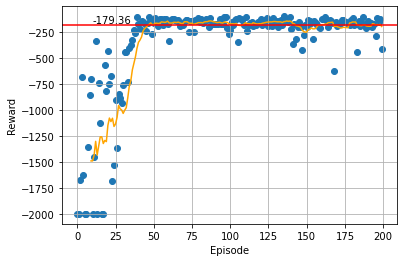

In [25]:
# Plot results
rewards_smoothed = pd.Series.rolling(pd.Series(rewards), 10).mean()
rewards_smoothed = [elem for elem in rewards_smoothed]
plt.scatter([i for i in range(len(rewards))], rewards)
plt.plot(rewards_smoothed, color='orange')
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.axhline(y=avg_last_100, color='r', linestyle='-')
plt.text(10, avg_last_100+15, avg_last_100)
plt.grid(True)

plt.savefig("qlearn.png", dpi=600)
plt.show()